# Part 1: The Prediction Challenge

As stated in the Challenge Statement, we are given a dataset from the "Urban Typologies" project, where we could find 65 indicators that relate to demographics, mobility, economy city form. We are expected to predict the **'CO2 Emissions per Capita(metric tonnes)'** for each city, conditioned on any other variables that we choose except the  **'Pollution Index'**. 

We start by importing the packages we need, reading in the dataset and doing some initial processing of the data. We will set the city ID as the index of the data frame and drop unecessary variables such as, 'City', 'Typology', 'Pollution Index'. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


df = pd.read_excel('Cities.xls', index_col=0, skipinitialspace=True) # Read with excel index. 
df.head()

,City,cityID,clusterID,Typology,Country,Car Modeshare (%),Public Transit Modeshare (%),Bicycle Modeshare (%),Walking Modeshare (%),Gasoline Pump Price (USD/liter),Road Deaths Rate (per 1000),Subway Length (km),Subway Length Density (per km),Subway Stations per Hundred Thousand,Subway Ridership per Capita,Subway Age (years),BRT Length (km),BRT System Length Density (per km),BRT Stations per Hundred Thousand Persons,BRT Fleet per Hundred Thousand Persons,BRT Annual Ridership per Capita,BRT Age (years),Bikeshare Stations,Bikeshare Stations per Hundred Thousand Persons,Bikeshare Number of Bikes,Bikeshare Bicycles per Hundred Thousand Persons,Bikeshare Age (years),Congestion (%),Congestion AM Peak (%),Congestion PM Peak (%),Traffic Index,Travel Time Index,Inefficiency Index,Population,Land Area (sq. km),Population Density (per sq. km),Population Change 1990 – 2000,Population Change 2000 – 2010,Population Change 2010 – 2020,Population Change 2020 – 2025,Urbanization Rate 2015 (%),Urbanization Rate Change 2015 – 2025 (pp),GDP per Capita (USD),Unemployment Rate (%),Cost of Living Index,Rent Index,Grocery Index,Restaurant Price Index,Local Purchasing Power Index,Gini Coefficient,Poverty Rate (%),Life Expectancy (years),Safety Index,Internet Penetration,Digital Penetration,Innovation Index,Smartphone Penetration (%),CO2 Emissions per Capita (metric tonnes),Pollution Index,Street length total (m),Street Length Density (m/sq. km),Street Length Average (m),Intersection Count,Intersection Density (per sq. km),Degree Average,Streets per Node,Circuity,Self-Loop Proportion,Highway Proportion,Metro Propensity Factor,BRT Propensity Factor,BikeShare Propensity Factor,Development Factor,Sustainability Factor,Population Factor,Congestion Factor,Sprawl Factor,Network Density Factor
284,Baltimore(MD),285,7,Auto Sprawl,United States,85.0,6.1,0.3,2.6,0.66,8.5,24.9,0.013409,0.615385,6.417582,34,0.0,0.000000,0.000000,0.000000,0.000000,0.0,50,2.197802,NaN,0.00000,2.0,19.0,33.0,46.0,148.97,36.90,150.22,2275000,1857,1200,233673,332204,399059,195708,81.6,1.7,58789.0,7.20,77.33,48.58,76.48,78.28,150.69,0.443,22.9,78.8,31.19,81.0,0.78,45.0,72.0,14.300000,NaN,7468900.983,7.604833e+09,148.013337,28660.0,1018.199702,5.021972,2.869906,1.067736,0.007910,0.041018,0.160848,0.176867,0.360637,0.796264,0.355964,0.081956,0.180085,0.722163,0.425187
9,Melbourne,10,8,Auto Innovative,Australia,80.0,14.0,2,4.0,1.11,5.4,0.0,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,50,1.264223,600.0,15.17067,2.0,33.0,55.0,58.0,143.12,35.57,138.17,3955000,2543,1500,316060,462816,715525,350883,89.4,1.2,39358.0,5.50,79.04,44.30,72.93,76.07,139.62,NaN,NaN,82.0,60.23,86.9,0.74,50.0,77.0,10.200000,26.77,8636838.530,8.653670e+09,107.503591,48571.0,1001.948856,4.948413,2.876305,1.036985,0.001626,0.014489,0.060387,0.168335,0.363675,0.786174,0.397894,0.082267,0.333173,0.539355,0.558910
185,Niamey,186,1,Congested Emerging,Niger,NaN,9.0,2,60.0,1.02,26.4,0.0,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0,0.000000,0.0,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1435000,130,11100,248392,541978,960996,741379,18.7,3.5,427.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.6,61.8,NaN,2.4,0.04,NaN,NaN,0.106861,NaN,2134329.200,3.496995e+09,97.860119,13033.0,1638.451450,6.161297,3.187450,1.019423,0.000095,0.000000,0.036220,0.010915,0.343161,0.000000,0.273646,0.248398,0.655464,0.275605,0.410312
327,Hanoi,328,12,MetroBike Emerging,Vietnam,8.0,10.0,2,NaN,0.90,24.5,0.0,0.000000,0.000000,0.000000,0,14.5,NaN,0.143000,NaN,0.149000,1.0,0,0.000000,0.0,0.00000,0.0,NaN,NaN,NaN,160.60,40.78,189.18,7445000,868,8600,520495,1149423,1391900,608994,33.6,6.3,3425.0,6.84,41.73,17.15,37.25,22.72,23.47,0.340,5.4,76.0,54.64,50.1,0.31,35.0,35.0,1.700368,89.66,8079366.816,1.156634e+09,300.370541,15881.0,143.158938,5.205795,2.870473,1.097533,0.000921,0.022938,0.078028,0.084511,0.358868,0.157676,0.509057,0.292564,0.624623,0.666710,0.239113
66,Urumqi,67,12,MetroBike Emerging,China,21.7,54.7,NaN,NaN,1.16,18.8

* Since there are already ID numbers assigned to each city, we can get rid of the additional indexing which provides the same information anyway. Since **'cityID'** provides the exact information as the **'City'** column, and **'Typology'** provides the exact information as the **'clusterID'**, we drop those. On top of all, since we are restricted to use **'Pollution Index'**, we also drop it out of our data set.

In [2]:
# Skip all white-spaces.
df = df.set_index('cityID') # Remove the indices and use cityID as index.

# Drop unnecessary columns (that explicitly imply each other)
# cityID implies City
# clusterID implies Typology
# Pollution Index is restricted to be used in prediction.
col2drop = ['City', 'Typology', 'Pollution Index ']



df.drop(col2drop, inplace=True, axis=1) 


* We are going to use our dataset in regression, so we don't want any non-numerical data in our dataset. By applying the operations above we are still left with a string type of column, which is **'Country'**. It is an important features that is possibly related to our target column (assumption), therefore we don't want to drop it out. So we decide to encode the country column into numbers. 

In [3]:
from sklearn.preprocessing import LabelEncoder

def multi_label_encoder(df, col):
        encoder = LabelEncoder()
        df[col+'(Encoded)'] = encoder.fit_transform(df[col])
        decode_dict = df[['Country', 'Country(Encoded)']].set_index('Country(Encoded)')['Country'].to_dict()
        df[col] = df[col+'(Encoded)']
        return df.drop(col+'(Encoded)', axis=1), decode_dict
    
df, decode_dict = multi_label_encoder(df, 'Country')

* Now since we encoded our **'Country'** column into numbers, and saved a dictionary for possible back-conversion later, let's see how our dataset now looks like:

In [4]:
df.head()

,clusterID,Country,Car Modeshare (%),Public Transit Modeshare (%),Bicycle Modeshare (%),Walking Modeshare (%),Gasoline Pump Price (USD/liter),Road Deaths Rate (per 1000),Subway Length (km),Subway Length Density (per km),Subway Stations per Hundred Thousand,Subway Ridership per Capita,Subway Age (years),BRT Length (km),BRT System Length Density (per km),BRT Stations per Hundred Thousand Persons,BRT Fleet per Hundred Thousand Persons,BRT Annual Ridership per Capita,BRT Age (years),Bikeshare Stations,Bikeshare Stations per Hundred Thousand Persons,Bikeshare Number of Bikes,Bikeshare Bicycles per Hundred Thousand Persons,Bikeshare Age (years),Congestion (%),Congestion AM Peak (%),Congestion PM Peak (%),Traffic Index,Travel Time Index,Inefficiency Index,Population,Land Area (sq. km),Population Density (per sq. km),Population Change 1990 – 2000,Population Change 2000 – 2010,Population Change 2010 – 2020,Population Change 2020 – 2025,Urbanization Rate 2015 (%),Urbanization Rate Change 2015 – 2025 (pp),GDP per Capita (USD),Unemployment Rate (%),Cost of Living Index,Rent Index,Grocery Index,Restaurant Price Index,Local Purchasing Power Index,Gini Coefficient,Poverty Rate (%),Life Expectancy (years),Safety Index,Internet Penetration,Digital Penetration,Innovation Index,Smartphone Penetration (%),CO2 Emissions per Capita (metric tonnes),Street length total (m),Street Length Density (m/sq. km),Street Length Average (m),Intersection Count,Intersection Density (per sq. km),Degree Average,Streets per Node,Circuity,Self-Loop Proportion,Highway Proportion,Metro Propensity Factor,BRT Propensity Factor,BikeShare Propensity Factor,Development Factor,Sustainability Factor,Population Factor,Congestion Factor,Sprawl Factor,Network Density Factor
cityID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
285,7,116,85.0,6.1,0.3,2.6,0.66,8.5,24.9,0.013409,0.615385,6.417582,34,0.0,0.000000,0.000000,0.000000,0.000000,0.0,50,2.197802,NaN,0.00000,2.0,19.0,33.0,46.0,148.97,36.90,150.22,2275000,1857,1200,233673,332204,399059,195708,81.6,1.7,58789.0,7.20,77.33,48.58,76.48,78.28,150.69,0.443,22.9,78.8,31.19,81.0,0.78,45.0,72.0,14.300000,7468900.983,7.604833e+09,148.013337,28660.0,1018.199702,5.021972,2.869906,1.067736,0.007910,0.041018,0.160848,0.176867,0.360637,0.796264,0.355964,0.081956,0.180085,0.722163,0.425187
10,8,5,80.0,14.0,2,4.0,1.11,5.4,0.0,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,50,1.264223,600.0,15.17067,2.0,33.0,55.0,58.0,143.12,35.57,138.17,3955000,2543,1500,316060,462816,715525,350883,89.4,1.2,39358.0,5.50,79.04,44.30,72.93,76.07,139.62,NaN,NaN,82.0,60.23,86.9,0.74,50.0,77.0,10.200000,8636838.530,8.653670e+09,107.503591,48571.0,1001.948856,4.948413,2.876305,1.036985,0.001626,0.014489,0.060387,0.168335,0.363675,0.786174,0.397894,0.082267,0.333173,0.539355,0.558910
186,1,77,NaN,9.0,2,60.0,1.02,26.4,0.0,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0,0.000000,0.0,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1435000,130,11100,248392,541978,960996,741379,18.7,3.5,427.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.6,61.8,NaN,2.4,0.04,NaN,NaN,0.106861,2134329.200,3.496995e+09,97.860119,13033.0,1638.451450,6.161297,3.187450,1.019423,0.000095,0.000000,0.036220,0.010915,0.343161,0.000000,0.273646,0.248398,0.655464,0.275605,0.410312
328,12,120,8.0,10.0,2,NaN,0.90,24.5,0.0,0.000000,0.000000,0.000000,0,14.5,NaN,0.143000,NaN,0.149000,1.0,0,0.000000,0.0,0.00000,0.0,NaN,NaN,NaN,160.60,40.78,189.18,7445000,868,8600,520495,1149423,1391900,608994,33.6,6.3,3425.0,6.84,41.73,17.15,37.25,22.72,23.47,0.340,5.4,76.0,54.64,50.1,0.31,35.0,35.0,1.700368,8079366.816,1.156634e+09,300.370541,15881.0,143.158938,5.205795,2.870473,1.097533,0.000921,0.022938,0.078028,0.084511,0.358868,0.157676,0.509057,0.292564,0.624623,0.666710,0.239113
67,12,21,21.7,54.7,NaN,NaN,1.16,18.8,0.0,0.000000,0.000000,0.000000,0,66.0,0.134146,2.537764,9.123867,34.441088,7.0,0,0.000000,0.0,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3310000,492,6700,55

In [5]:
df.describe()

,clusterID,Country,Car Modeshare (%),Public Transit Modeshare (%),Walking Modeshare (%),Gasoline Pump Price (USD/liter),Road Deaths Rate (per 1000),Subway Length (km),Subway Length Density (per km),Subway Stations per Hundred Thousand,Subway Ridership per Capita,Subway Age (years),BRT Length (km),BRT System Length Density (per km),BRT Stations per Hundred Thousand Persons,BRT Fleet per Hundred Thousand Persons,BRT Annual Ridership per Capita,BRT Age (years),Bikeshare Stations per Hundred Thousand Persons,Bikeshare Number of Bikes,Bikeshare Bicycles per Hundred Thousand Persons,Bikeshare Age (years),Congestion (%),Congestion AM Peak (%),Congestion PM Peak (%),Traffic Index,Travel Time Index,Inefficiency Index,Population,Land Area (sq. km),Population Density (per sq. km),Population Change 1990 – 2000,Population Change 2000 – 2010,Population Change 2010 – 2020,Population Change 2020 – 2025,Urbanization Rate 2015 (%),Urbanization Rate Change 2015 – 2025 (pp),GDP per Capita (USD),Unemployment Rate (%),Cost of Living Index,Rent Index,Grocery Index,Restaurant Price Index,Local Purchasing Power Index,Gini Coefficient,Poverty Rate (%),Life Expectancy (years),Safety Index,Internet Penetration,Digital Penetration,Innovation Index,Smartphone Penetration (%),CO2 Emissions per Capita (metric tonnes),Street length total (m),Street Length Density (m/sq. km),Street Length Average (m),Intersection Count,Intersection Density (per sq. km),Degree Average,Streets per Node,Circuity,Self-Loop Proportion,Highway Proportion,Metro Propensity Factor,BRT Propensity Factor,BikeShare Propensity Factor,Development Factor,Sustainability Factor,Population Factor,Congestion Factor,Sprawl Factor,Network Density Factor
count,331.000000,331.000000,224.000000,227.000000,199.000000,331.000000,330.000000,331.000000,331.000000,331.000000,331.000000,331.000000,330.000000,329.000000,321.000000,300.000000,330.000000,316.000000,330.000000,313.000000,316.000000,328.000000,165.000000,165.000000,165.000000,142.000000,142.000000,142.000000,3.310000e+02,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,328.000000,328.000000,331.000000,193.000000,223.000000,223.000000,223.000000,223.000000,223.000000,226.000000,194.000000,331.000000,207.000000,330.000000,324.000000,258.000000,219.000000,331.000000,3.170000e+02,3.170000e+02,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,5.567976,67.126888,47.688694,25.999218,18.270352,1.053988,14.707576,38.872356,0.037598,0.729446,25.634767,16.199396,10.533455,0.013815,0.413424,1.690402,4.282701,3.126582,1.717524,1507.434505,28.744784,1.917683,29.387879,46.654545,57.539394,170.634718,40.236268,181.698099,4.343458e+06,1048.232628,6107.362538,5.650781e+05,6.583977e+05,8.284136e+05,4.069141e+05,67.545732,3.545732,25398.480846,7.807409,58.721121,28.269910,53.744439,52.883767,83.786637,0.427235,21.290825,74.402523,52.420483,57.426667,0.524599,39.678295,53.452055,7.397879,7.116418e+06,5.322874e+09,157.060505,28596.160883,1742.295843,5.112775,2.877538,1.066236,0.002914,0.016953,0.195855,0.173344,0.398780,0.416785,0.381920,0.171709,0.491645,0.492904,0.412400
std,3.591750,38.901689,28.588289,20.319709,15.845304,0.424823,8.718870,77.291871,0.068359,1.224042,48.264312,27.430951,25.093831,0.034030,1.074162,7.928495,12.671217,7.171579,4.722804,7587.973979,117.482423,3.358670,10.346785,17.249127,17.637093,55.197757,8.999045,75.456951,5.175587e+06,1303.503455,5264.683635,8.691368e+05,8.745002e+05,1.033509e+06,5.137592e+05,19.183544,2.667355,22422.648624,6.235819,20.934314,20.337176,21.468003,24.713496,39.246045,0.090711,12.611445,7.206536,15.514069,24.497672,0.220449,7.598970,19.906461,6.538615,1.005218e+07,3.538891e+09,85.743576,32794.221029,2998.022258,0.471003,0.208571,0.031631,0.003780,0.016285,0.195584,0.148059,0.078614,0.266073,0.153003,0.159347,0.189305,0.227212,0.151951
min,1.000000,0.0

* We see that some columns seem to miss values looking at the **'count'** row in the pandas.DataFrame.describe() output. Now, we check in-depth what is the situation with missing values.


In [6]:
# Checking the % of missing values for each column.
missData = pd.DataFrame(df.isnull().sum(axis=0), columns=['Missing Values (%)'])/df.count()[0]*100 
missData = missData.sort_values(by=missData.columns[0], ascending=False)
pd.set_option('display.max_columns', 1000)
missData.T.head()

,Traffic Index,Inefficiency Index,Travel Time Index,Congestion PM Peak (%),Congestion (%),Congestion AM Peak (%),Bicycle Modeshare (%),Unemployment Rate (%),Poverty Rate (%),Walking Modeshare (%),Safety Index,Smartphone Penetration (%),Local Purchasing Power Index,Restaurant Price Index,Grocery Index,Rent Index,Cost of Living Index,Car Modeshare (%),Gini Coefficient,Public Transit Modeshare (%),Innovation Index,BRT Fleet per Hundred Thousand Persons,Bikeshare Number of Bikes,Bikeshare Bicycles per Hundred Thousand Persons,BRT Age (years),Intersection Density (per sq. km),Intersection Count,Degree Average,Self-Loop Proportion,Street Length Average (m),Streets per Node,Circuity,Street Length Density (m/sq. km),Highway Proportion,Street length total (m),BRT Stations per Hundred Thousand Persons,Digital Penetration,Bikeshare Stations,Urbanization Rate 2015 (%),Urbanization Rate Change 2015 – 2025 (pp),Bikeshare Age (years),BRT System Length Density (per km),Bikeshare Stations per Hundred Thousand Persons,BRT Annual Ridership per Capita,Internet Penetration,Road Deaths Rate (per 1000),BRT Length (km),Metro Propensity Factor,BikeShare Propensity Factor,Development Factor,Sustainability Factor,Population Factor,Congestion Factor,BRT Propensity Factor,Sprawl Factor,clusterID,CO2 Emissions per Capita (metric tonnes),Life Expectancy (years),Gasoline Pump Price (USD/liter),Subway Length (km),Subway Length Density (per km),Subway Stations per Hundred Thousand,Subway Ridership per Capita,Subway Age (years),Population,Land Area (sq. km),Population Density (per sq. km),Population Change 1990 – 2000,Population Change 2000 – 2010,Population Change 2010 – 2020,Population Change 2020 – 2025,Country,GDP per Capita (USD),Network Density Factor
Missing Values (%),57.099698,57.099698,57.099698,50.151057,50.151057,50.151057,44.108761,41.691843,41.389728,39.879154,37.462236,33.836858,32.628399,32.628399,32.628399,32.628399,32.628399,32.326284,31.722054,31.41994,22.054381,9.365559,5.438066,4.531722,4.531722,4.229607,4.229607,4.229607,4.229607,4.229607,4.229607,4.229607,4.229607,4.229607,4.229607,3.021148,2.114804,0.906344,0.906344,0.906344,0.906344,0.60423,0.302115,0.302115,0.302115,0.302115,0.302115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* Taking a look at the outputs above, we notice that there are many values missing in many of the columns. It is not feasible to impute the values if there are too many values missing. It's not likely that the existing values would be sufficient enough to generalize the column, so trying to impute the missing data could corrupt the column instead of making it useful.  But on the other hand, it's not really feasible to drop all the columns if the number of missing values in the column is relatively small - because it might be possible to somewhat reliably impute the missing values.

There's no golden rule to perform such operation, so we decide to drop columns that are missing more than 25% of their values. 

In [7]:
# missData is transposed only during display above. normally the dataframe has 1 column e.g. Missing Values (%).
cols2drop = missData[missData['Missing Values (%)']>=25].index
df = df.drop(cols2drop, axis=1)
df.head()

,clusterID,Country,Gasoline Pump Price (USD/liter),Road Deaths Rate (per 1000),Subway Length (km),Subway Length Density (per km),Subway Stations per Hundred Thousand,Subway Ridership per Capita,Subway Age (years),BRT Length (km),BRT System Length Density (per km),BRT Stations per Hundred Thousand Persons,BRT Fleet per Hundred Thousand Persons,BRT Annual Ridership per Capita,BRT Age (years),Bikeshare Stations,Bikeshare Stations per Hundred Thousand Persons,Bikeshare Number of Bikes,Bikeshare Bicycles per Hundred Thousand Persons,Bikeshare Age (years),Population,Land Area (sq. km),Population Density (per sq. km),Population Change 1990 – 2000,Population Change 2000 – 2010,Population Change 2010 – 2020,Population Change 2020 – 2025,Urbanization Rate 2015 (%),Urbanization Rate Change 2015 – 2025 (pp),GDP per Capita (USD),Life Expectancy (years),Internet Penetration,Digital Penetration,Innovation Index,CO2 Emissions per Capita (metric tonnes),Street length total (m),Street Length Density (m/sq. km),Street Length Average (m),Intersection Count,Intersection Density (per sq. km),Degree Average,Streets per Node,Circuity,Self-Loop Proportion,Highway Proportion,Metro Propensity Factor,BRT Propensity Factor,BikeShare Propensity Factor,Development Factor,Sustainability Factor,Population Factor,Congestion Factor,Sprawl Factor,Network Density Factor
cityID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
285,7,116,0.66,8.5,24.9,0.013409,0.615385,6.417582,34,0.0,0.000000,0.000000,0.000000,0.000000,0.0,50,2.197802,NaN,0.00000,2.0,2275000,1857,1200,233673,332204,399059,195708,81.6,1.7,58789.0,78.8,81.0,0.78,45.0,14.300000,7468900.983,7.604833e+09,148.013337,28660.0,1018.199702,5.021972,2.869906,1.067736,0.007910,0.041018,0.160848,0.176867,0.360637,0.796264,0.355964,0.081956,0.180085,0.722163,0.425187
10,8,5,1.11,5.4,0.0,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,50,1.264223,600.0,15.17067,2.0,3955000,2543,1500,316060,462816,715525,350883,89.4,1.2,39358.0,82.0,86.9,0.74,50.0,10.200000,8636838.530,8.653670e+09,107.503591,48571.0,1001.948856,4.948413,2.876305,1.036985,0.001626,0.014489,0.060387,0.168335,0.363675,0.786174,0.397894,0.082267,0.333173,0.539355,0.558910
186,1,77,1.02,26.4,0.0,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0,0.000000,0.0,0.00000,0.0,1435000,130,11100,248392,541978,960996,741379,18.7,3.5,427.4,61.8,2.4,0.04,NaN,0.106861,2134329.200,3.496995e+09,97.860119,13033.0,1638.451450,6.161297,3.187450,1.019423,0.000095,0.000000,0.036220,0.010915,0.343161,0.000000,0.273646,0.248398,0.655464,0.275605,0.410312
328,12,120,0.90,24.5,0.0,0.000000,0.000000,0.000000,0,14.5,NaN,0.143000,NaN,0.149000,1.0,0,0.000000,0.0,0.00000,0.0,7445000,868,8600,520495,1149423,1391900,608994,33.6,6.3,3425.0,76.0,50.1,0.31,35.0,1.700368,8079366.816,1.156634e+09,300.370541,15881.0,143.158938,5.205795,2.870473,1.097533,0.000921,0.022938,0.078028,0.084511,0.358868,0.157676,0.509057,0.292564,0.624623,0.666710,0.239113
67,12,21,1.16,18.8,0.0,0.000000,0.000000,0.000000,0,66.0,0.134146,2.537764,9.123867,34.441088,7.0,0,0.000000,0.0,0.00000,0.0,3310000,492,6700,556511,1249115,1610288,491541,55.6,9.8,12189.0,76.1,50.1,0.43,NaN,7.550916,8891135.865,2.169530e+08,546.944874,9567.0,24.401041,4.736409,2.680313,1.064157,0.000348,0.060128,0.103334,0.447261,0.392551,0.287235,0.801464,0.322960,0.586019,0.791822,0.075617


* Since we applied our threshold filtering on the missing data, now we need to replace the remaining empty cells in some way. Here, we mainly considered two methods, namely, to predict the values of each column one by one or to replace the values in each column with the mean(if float)/ mode(if binary). We didn't include the results with the predictions (we tried decision trees) for the sake of simplicity but as a result it turned out that predicting the missing values gave worse results than simply replacing the missing values with the columns mean/mode.

Below we implement a function that fills in the missing values by their means and modes depending on if they are integers or floats (e.g. since we cannot have a population with a floating numbers and alike).

In [8]:
def replace_missing_val(df):
    
    df = df.replace(r'^\s*$', np.NaN, regex=True)
    # print("Initial dataframe shape [rows, columns]:", df.shape)
    n_NaN = df.isna().sum().sum()
    # print(n_NaN) # As you can see the total number of NaNs in the database 3199, so we need to impute.

    # Impute all NaNs over the database.

    df_int = df.select_dtypes(include='integer')
    df_float = df.select_dtypes(include='float')

    df_int = df_int.fillna(df.mode().iloc[0]) # Try using mean/mod for different columns.
    df_float = df_float.fillna(df.mean().iloc[0]) # Try using mean/mod for different columns.

    df[df_int.columns.values.tolist()] = df_int # Use mod for integers,
    df[df_float.columns.values.tolist()] = df_float # Use mean for floats

    # Drop taget variable
    # df_targets = df['CO2 Emissions per Capita (metric tonnes)']
    # df_inputs = df.drop(columns=['CO2 Emissions per Capita (metric tonnes)'])
    # return df_inputs, df_targets
    return df


In [9]:
df = replace_missing_val(df)
print('The number of missing values in the dataset: {}'.format(df.isna().sum().sum()))
print('The size of the cleaned dataset: {}'.format(df.shape))

The number of missing values in the dataset: 0
The size of the cleaned dataset: (331, 54)


As you can see above, now we have no missing values in the remaining dataset. Now the actual manipulation and analysis of the data can take place with our cleaned data that is ready for action. 

An inital prediction was attempted without any processing of the data, but as expected a relativly low R^2 score was attained (almost 0.4). The initial idea to improve the score would be to try multiple prediction algorithms and to reduce the dimensionality of the dataset. 

Random forest regression, support vector regression and multilayer perceptron regression were all tested to predict the target variable. It turned out to be the multilayer perceptron model from the sklearn neural_network package which performed the best. As for dimensionality reduction, PCA analysis was used as well as utilizing the co-correlation and co-variance within the data set. It turned out to be that dropping columns of low variance (under a given threshold) produced the best result. Using the variance threshold method, a total of 44 columns were dropped, which means (as seen in the code outputs below) using 30 variables in the final model was enough to predict the target.     

## Feature Selection:

In this part we will discuss which columns that we are going to use for prediction and why, or what other techniques that we are going to use before training a model.

* First, let's have a look at the correlation matrix of the dataset.

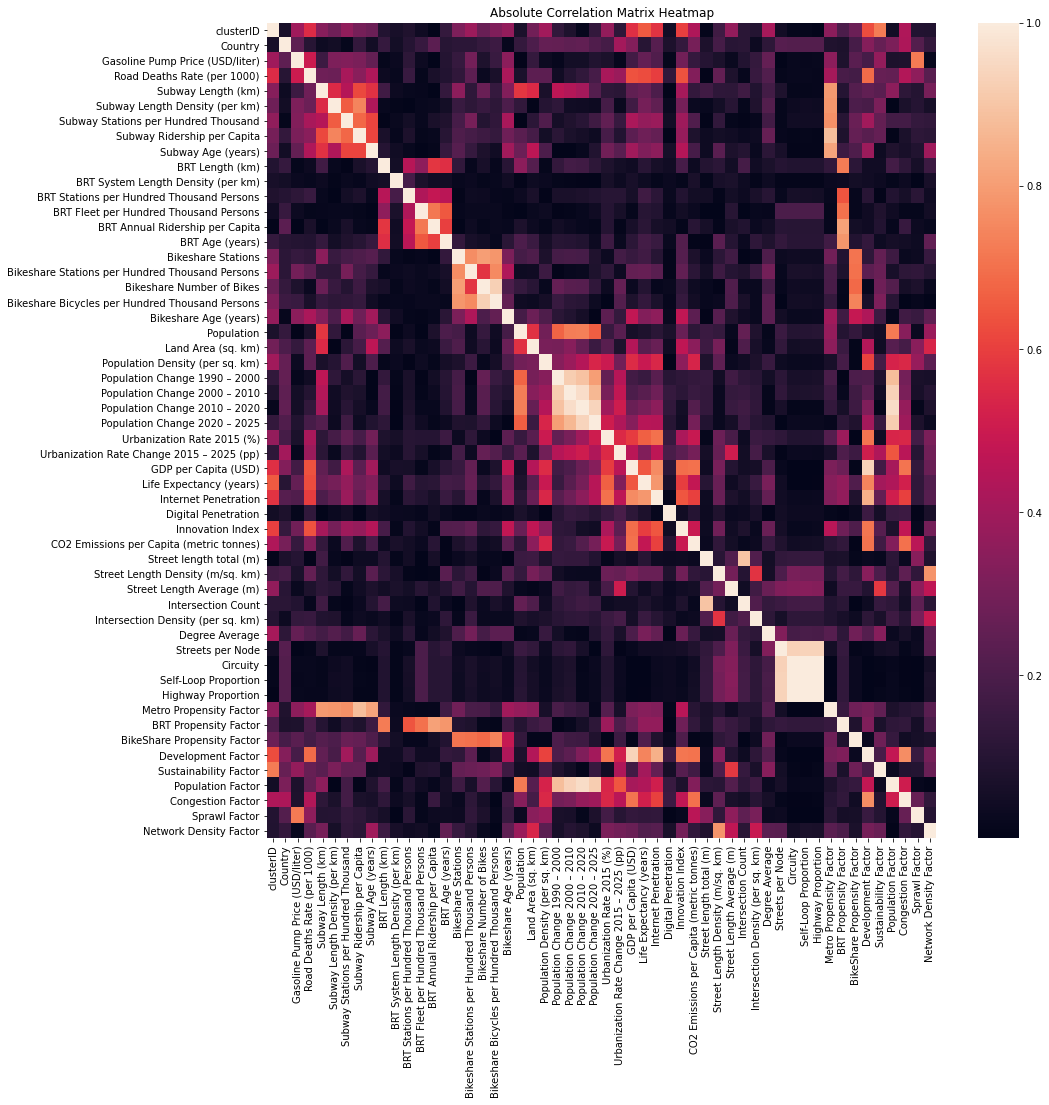

In [10]:
import seaborn as sns
corr = df.corr().abs()

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, ax=ax)
ax.set_title('Absolute Correlation Matrix Heatmap');

* Our dataset consists of too many columns, so it's really hard to see and analyze the features that are correlated with each other one by one. So instead, we have plotted a heatmap of the absolute values of the correlation matrix to see if there are many number of columns that are correlated with each other. 


* From the heatmap, we see that we have many correlated variables that are highly correlated. Correlated variables generally don't improve the prediction models and they might actually impact the performance of the models in a bad way. So, it seems feasible to consider a dimensionality reduction technique right away from the start. 

For dimensionality reduction, we will consider two approaches: PCA and correlation thresholding.

### Dimensionality Reduction - Approach 1:
#### Filtering Out 1 of Each Highly Correlated Feature Couples:

Principle component analysis, itself, takes care of the correlations already so each of the resulting components are orthogonal to each other. But we also wanted to try implementing a function for filtering out highly correlated columns.

In [11]:
def corr_filter(df_in, thresh):
    corr = df_in.corr().abs()
    up_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)) # Get the upper triangle.
    to_drop = [column for column in up_tri.columns if any(up_tri[column] > thresh)]
    df_in = df_in.drop(to_drop, axis=1)
    return df_in


<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 285 to 225
Data columns (total 16 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   clusterID                                  331 non-null    int64  
 1   Country                                    331 non-null    int32  
 2   Gasoline Pump Price (USD/liter)            331 non-null    float64
 3   Subway Length (km)                         331 non-null    float64
 4   BRT Length (km)                            331 non-null    float64
 5   BRT System Length Density (per km)         331 non-null    float64
 6   BRT Stations per Hundred Thousand Persons  331 non-null    float64
 7   BRT Fleet per Hundred Thousand Persons     331 non-null    float64
 8   Bikeshare Stations                         331 non-null    float64
 9   Bikeshare Age (years)                      331 non-null    float64
 10  Population Density (per 

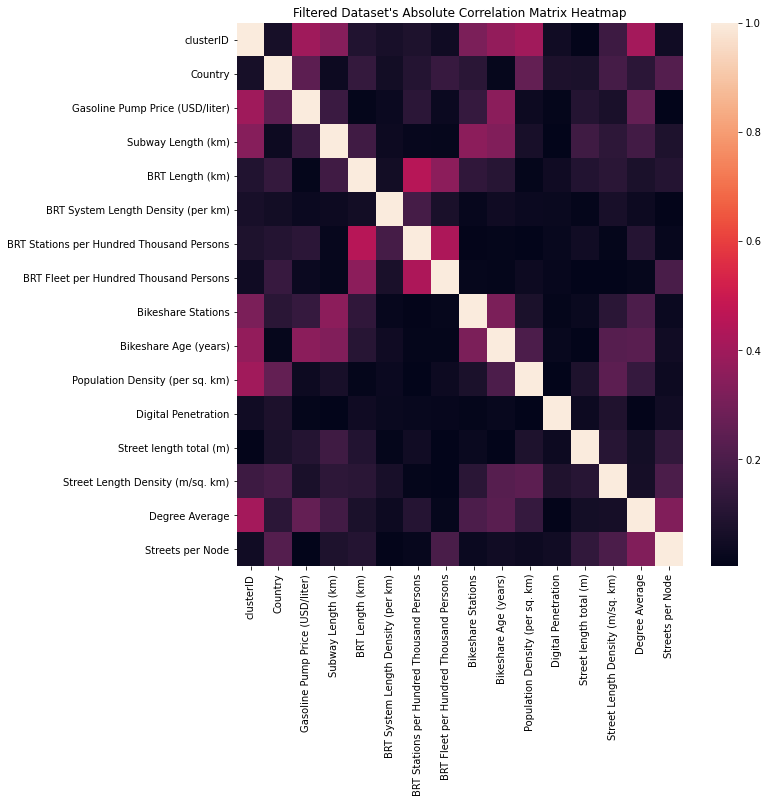

In [12]:
filtered = corr_filter(df.copy().drop('CO2 Emissions per Capita (metric tonnes)', axis=1), 0.5)

filtered.info()

import seaborn as sns
corr = filtered.corr().abs()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, ax=ax)
ax.set_title('Filtered Dataset\'s Absolute Correlation Matrix Heatmap');

* Again, there's no rule golden rule for deciding what should be the threshold to accept a correlation to be high, we  decided get rid of one of the columns that are correlated with each other with a score higher than 0.5. Please note that we didn't include the target column in correlation filtering

As you can see by the output above there are no highly correlated features left in the dataset. The remaining number of columns is 15 (from 53). 

### Dimensionality Reduction: Approach 2:
#### Principle Component Analysis:

For PCA, the inputs **must** have unit variance and zero mean, otherwise PCA results will be biased over variables that has larger scaling, which is technically faulty. So we use standardization on the dataset that is going to be used with PCA, but not yet on the filtered one.

In [13]:
# Define the standardization function.
def standardize_dataframe(df_in):
    return (df_in-df_in.mean())/df_in.std()

In [14]:
# PCA inputs without filtering:
df_target = df['CO2 Emissions per Capita (metric tonnes)']
df_inputs = standardize_dataframe(df.drop('CO2 Emissions per Capita (metric tonnes)', axis=1))

* In the following cells we create train and test splits with correlation filtered and non-filtered datasets, seperately.

Text(0.5, 1.0, 'Cumulative Variance Explained (%)')

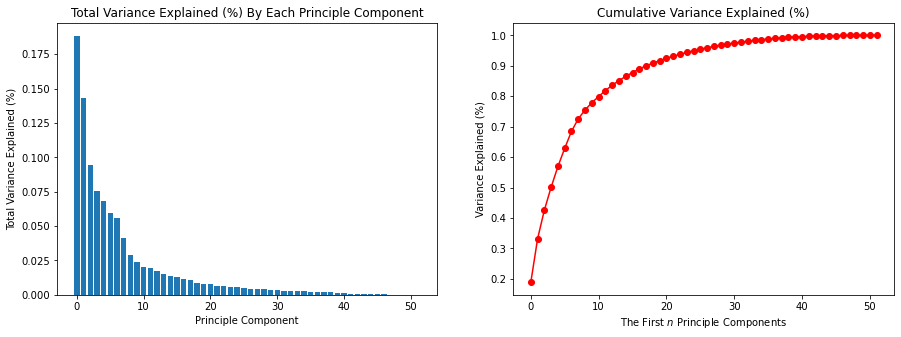

In [15]:
# Perform PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=.999999)

pca.fit(df_inputs)
expl=pca.explained_variance_ratio_
cdf=[sum(expl[:i+1]) for i in range(len(expl))]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].bar(range(len(expl)),pca.explained_variance_ratio_)
ax[0].set_xlabel('Principle Component')
ax[0].set_ylabel('Total Variance Explained (%)')
ax[0].set_title('Total Variance Explained (%) By Each Principle Component')


ax[1].plot(range(len(expl)), cdf, marker='o', color='r');
ax[1].set_xlabel('The First $n$ Principle Components')
ax[1].set_ylabel('Variance Explained (%)')
ax[1].set_title('Cumulative Variance Explained (%)')

By the plots above you can see which principle component explains how much of the total variance in the dataset and  the cumulative explained variance by choosing the first $n$ principle components.

* Trying out a few alternatives we decided to use the first 18 principle components as it's on the elbow of the plot, and still explains 90% of the total variation. In the cell below, we perform the transformations on our standardized inputs according to the first 18 principle components.

In [16]:
print('The dimensions of the input dataset before PC transformation: {}'.format(df_inputs.shape))
pca18 = PCA(n_components=18)
df_inputs_PCA = pca18.fit_transform(df_inputs)
print('The dimensions of the input dataset after dimensionality reduction: {}'.format(df_inputs_PCA.shape))


The dimensions of the input dataset before PC transformation: (331, 53)
The dimensions of the input dataset after dimensionality reduction: (331, 18)


As you can see above the number of features to be used decreased from 53 to 18.

## The Prediction Models

### 1. Forming the Test and the Training Data:

In the following cell the test and train splits are created for both the PCA and the correlation filtering cases. 

We make sure that the dataset is not shuffled. **Setting the shuffle parameter in train_test_split() ensures that we don't shuffle the data, and by default it takes the training portion from the top rows of the dataset first then uses the bottom remaining ones as the test split, so the splits here are formed correctly as wanted in the challenge document.**

* We will also apply min/max scaling(because unlike in PCA case, we don't need to sustain unit variance and zero mean here) on the correlation filtered dataset as an extra case to see if it will provide any better results.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

# PCA outputs are splitted:
tr_inputs, ts_inputs, tr_target, ts_target = \
                        train_test_split(df_inputs_PCA, df_target, test_size=0.25, \
                                         random_state=42, shuffle=False)

# Creating splits where the dimensionality reduction is performed using correlation filtering:
fil_df_target = df['CO2 Emissions per Capita (metric tonnes)']
fil_df_inputs = filtered
fil_tr_inputs, fil_ts_inputs, fil_tr_target, fil_ts_target = \
                        train_test_split(fil_df_inputs, fil_df_target, test_size=0.25,\
                                         random_state=42, shuffle=False)

sc_fil_df_target = df['CO2 Emissions per Capita (metric tonnes)']
sc_fil_df_inputs = minmax_scale(filtered)

sc_fil_tr_inputs, sc_fil_ts_inputs, sc_fil_tr_target, sc_fil_ts_target = \
                        train_test_split(sc_fil_df_inputs, sc_fil_df_target, test_size=0.25,\
                                         random_state=42, shuffle=False)



* Since both of our datasets have so many dimensions, it's not possible to visualize them as they are. So we directly start training different types of models. 

### 2. Training Different Models and Hyperparameter Tuning

In this section, we try training different models to see if we could hit the goal ($R^2$>=0.55) or how good results that we can get with each model. 



In the cell below we will train Linear Regression models as baselines for:


* PCA performed data
* Non-Scaled Correlation filtered data

and we calculate $R^2$-scores for the models found for each. **Please note that Linear Regression is not susceptible against non-standardized data, so we don't standardize or normalize the correlation filtered dataset.**


After the next cell, we will proceed with training other models. At the end, we will plot all the results on the same figure for performance comparison.


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge

R2_lin_PCA = LinearRegression().fit(tr_inputs, tr_target).score(ts_inputs, ts_target)
R2_lin_Corr = LinearRegression().fit(fil_tr_inputs, fil_tr_target).score(fil_ts_inputs, fil_ts_target)

In the cell below we carry out hyperparameter tuning via GridSearchCV() on:

* Random Forest Regression with PCA performed data
* Random Forest Regression with Non-Scaled Correlation filtered data

and we calculate $R^2$-scores for the best models found for each.

**Please note since Random Forests are robust against non-standardized data, so we don't need to train a new model for the standardized or the normalized version of the correlation filtered dataset.**

In [19]:
from sklearn.ensemble import RandomForestRegressor

# # Parameters to perform search on.
# params = {
#     'bootstrap': [False, True],
#     'max_depth': [5, 15, 25, 35],
#     'min_samples_leaf': [2, 4, 8, 15],
#     'min_samples_split': [5, 10, 15, 20],
#     'n_estimators': [50, 100, 150, 200]
# }
# regrPCA = RandomForestRegressor()
# regrCor = RandomForestRegressor()

# gridPCA_rf = GridSearchCV(estimator = regrPCA, param_grid = params, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# gridCor_rf = GridSearchCV(estimator = regrCor, param_grid = params, 
#                           cv = 3, n_jobs = -1, verbose = 2)

# gridPCA_rf.fit(tr_inputs, tr_target)
# gridCor_rf.fit(fil_tr_inputs, fil_tr_target)

# R2_rf_PCA = gridPCA_rf.best_estimator_.score(ts_inputs, ts_target) # R2 score of the best model for PCA
# R2_rf_Cor = gridCor_rf.best_estimator_.score(fil_ts_inputs, fil_ts_target) # R2 score of the best model for correlation filtered dataset.

params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

# Parameters to perform search on.
R2_rf_PCA = RandomForestRegressor(**params)\
                .fit(tr_inputs, tr_target).score(ts_inputs, ts_target)

params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
R2_rf_Corr = RandomForestRegressor(**params)\
                .fit(fil_tr_inputs, fil_tr_target).score(fil_ts_inputs, fil_ts_target)



* We tried many different combinations of parameters and also ran grid search(which take a lot of time so we commented out the code here). We couldn't exceed an $R^2$-score of 0.55 so we gave up. 

In the cell below we carry out hyperparameter tuning for Both Linear/Non-linear Support Vector Regression via GridSearchCV() on:

* PCA performed data
* Standardized and normalized correlation filtered data

Since SVR required the inputs to be standardized, we didn't create a model with the non-standardized version of the correlation filtered dataset.

In [20]:
from sklearn.svm import SVR

# params = {'kernel':['linear', 'rbf' , 'sigmoid'],
#           'C':[0.001, 0.01, 0.1, 1, 10],
#           'gamma':['scale', 'auto']}

# regrSVR_PCA = SVR()
# regrSVR_Cor = SVR()
# regrSVR_Cor_scale = SVR()

# gridPCA_SVR = GridSearchCV(estimator = regrSVR_PCA, param_grid = params, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# gridCor_SVR = GridSearchCV(estimator = regrSVR_Cor, param_grid = params, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# gridCor_scaled_SVR = GridSearchCV(estimator = regrSVR_Cor_scale, param_grid = params, 
#                           cv = 3, n_jobs = -1, verbose = 2)

# gridPCA_SVR.fit(tr_inputs, tr_target)
# gridCor_SVR.fit(fil_tr_inputs, fil_tr_target)
# gridCor_scaled_SVR.fit(sc_fil_tr_inputs, sc_fil_tr_target)

# R2_svr_PCA = gridPCA_SVR.best_estimator_.score(ts_inputs, ts_target)
# R2_svr_Cor = gridCor_SVR.best_estimator_.score(fil_ts_inputs, fil_ts_target)
# R2_svr_Cor_scaled = gridCor_scaled_SVR.best_estimator_.score(sc_fil_ts_inputs, sc_fil_ts_target)

params = {'kernel':'linear',
          'C': 1,
          'gamma': 'auto',
          'epsilon': 3.12}
R2_svr_PCA = SVR(**params).fit(tr_inputs, tr_target).score(ts_inputs, ts_target)


params = {'kernel':'linear',
          'C': 1,
          'gamma': 'auto',
          'epsilon': 2.5}
R2_svr_Cor_scaled = SVR(**params).fit(sc_fil_tr_inputs, sc_fil_tr_target).score(sc_fil_ts_inputs, sc_fil_ts_target)

Linear kernel seemed to perform better. But again, we tried many different combinations of parameters and also ran grid search. But we again couldn't manage to exceed an 𝑅2-score of 0.55 with SVR so we gave up. 

In the cell below we defined and tuned (manually) a Neural Network on:

* PCA performed data

**Apparently we managed to exceed the goal value with an $R^2$-score=~0.62 which is bigger than 0.55 so we didn't train another model further on.**

In [21]:
# Perform predictions

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# define the keras model
modelPCA = Sequential()
modelPCA.add(Dense(128, input_dim=np.shape(tr_inputs)[1], activation='relu'))
modelPCA.add(Dense(128, activation='relu'))
modelPCA.add(Dense(128, activation='relu'))

modelPCA.add(Dense(1, activation='linear')) # Output layer.


# compile the keras model
opt = Adam(learning_rate=2e-5)
modelPCA.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
modelPCA.fit(tr_inputs, tr_target, epochs=900, batch_size=24, verbose=1) # Do not print the progress since 3500 epochs.


Epoch 1/900
11/11 [==============================] - 0s 974us/step - loss: 89.0216 - mean_squared_error: 89.0216
Epoch 2/900
11/11 [==============================] - 0s 980us/step - loss: 88.0679 - mean_squared_error: 88.0679
Epoch 3/900
11/11 [==============================] - 0s 902us/step - loss: 87.1243 - mean_squared_error: 87.1243
Epoch 4/900
11/11 [==============================] - 0s 1ms/step - loss: 86.1839 - mean_squared_error: 86.1839
Epoch 5/900
11/11 [==============================] - 0s 1ms/step - loss: 85.2370 - mean_squared_error: 85.2370
Epoch 6/900
11/11 [==============================] - 0s 1ms/step - loss: 84.3196 - mean_squared_error: 84.3196
Epoch 7/900
11/11 [==============================] - 0s 1ms/step - loss: 83.4016 - mean_squared_error: 83.4016
Epoch 8/900
11/11 [==============================] - 0s 2ms/step - loss: 82.4843 - mean_squared_error: 82.4843
Epoch 9/900
11/11 [==============================] - 0s 960us/step - loss: 81.5891 - mean_squared_error: 8

11/11 [==============================] - 0s 886us/step - loss: 12.4886 - mean_squared_error: 12.4886
Epoch 145/900
11/11 [==============================] - 0s 866us/step - loss: 12.4530 - mean_squared_error: 12.4530
Epoch 146/900
11/11 [==============================] - 0s 880us/step - loss: 12.4325 - mean_squared_error: 12.4325
Epoch 147/900
11/11 [==============================] - 0s 868us/step - loss: 12.3854 - mean_squared_error: 12.3854
Epoch 148/900
11/11 [==============================] - 0s 779us/step - loss: 12.3562 - mean_squared_error: 12.3562
Epoch 149/900
11/11 [==============================] - 0s 879us/step - loss: 12.3299 - mean_squared_error: 12.3299
Epoch 150/900
11/11 [==============================] - 0s 917us/step - loss: 12.2966 - mean_squared_error: 12.2966
Epoch 151/900
11/11 [==============================] - 0s 907us/step - loss: 12.2699 - mean_squared_error: 12.2699
Epoch 152/900
11/11 [==============================] - 0s 898us/step - loss: 12.2470 - mean_sq

Epoch 285/900
11/11 [==============================] - 0s 997us/step - loss: 10.2454 - mean_squared_error: 10.2454
Epoch 286/900
11/11 [==============================] - 0s 907us/step - loss: 10.2271 - mean_squared_error: 10.2271
Epoch 287/900
11/11 [==============================] - 0s 982us/step - loss: 10.2210 - mean_squared_error: 10.2210
Epoch 288/900
11/11 [==============================] - 0s 996us/step - loss: 10.2088 - mean_squared_error: 10.2088
Epoch 289/900
11/11 [==============================] - 0s 786us/step - loss: 10.1987 - mean_squared_error: 10.1987
Epoch 290/900
11/11 [==============================] - 0s 936us/step - loss: 10.1858 - mean_squared_error: 10.1858
Epoch 291/900
11/11 [==============================] - 0s 893us/step - loss: 10.1722 - mean_squared_error: 10.1722
Epoch 292/900
11/11 [==============================] - 0s 989us/step - loss: 10.1614 - mean_squared_error: 10.1614
Epoch 293/900
11/11 [==============================] - 0s 907us/step - loss: 10.

11/11 [==============================] - 0s 897us/step - loss: 8.8090 - mean_squared_error: 8.8090
Epoch 427/900
11/11 [==============================] - 0s 904us/step - loss: 8.8061 - mean_squared_error: 8.8061
Epoch 428/900
11/11 [==============================] - 0s 780us/step - loss: 8.7858 - mean_squared_error: 8.7858
Epoch 429/900
11/11 [==============================] - 0s 898us/step - loss: 8.7762 - mean_squared_error: 8.7762
Epoch 430/900
11/11 [==============================] - 0s 897us/step - loss: 8.7683 - mean_squared_error: 8.7683
Epoch 431/900
11/11 [==============================] - 0s 997us/step - loss: 8.7561 - mean_squared_error: 8.7561
Epoch 432/900
11/11 [==============================] - 0s 1ms/step - loss: 8.7518 - mean_squared_error: 8.7518
Epoch 433/900
11/11 [==============================] - 0s 1ms/step - loss: 8.7423 - mean_squared_error: 8.7423
Epoch 434/900
11/11 [==============================] - 0s 999us/step - loss: 8.7277 - mean_squared_error: 8.7277
E

11/11 [==============================] - 0s 805us/step - loss: 7.4795 - mean_squared_error: 7.4795
Epoch 571/900
11/11 [==============================] - 0s 826us/step - loss: 7.4697 - mean_squared_error: 7.4697
Epoch 572/900
11/11 [==============================] - 0s 803us/step - loss: 7.4654 - mean_squared_error: 7.4654
Epoch 573/900
11/11 [==============================] - 0s 857us/step - loss: 7.4525 - mean_squared_error: 7.4525
Epoch 574/900
11/11 [==============================] - 0s 896us/step - loss: 7.4452 - mean_squared_error: 7.4452
Epoch 575/900
11/11 [==============================] - 0s 716us/step - loss: 7.4452 - mean_squared_error: 7.4452
Epoch 576/900
11/11 [==============================] - 0s 997us/step - loss: 7.4275 - mean_squared_error: 7.4275
Epoch 577/900
11/11 [==============================] - 0s 998us/step - loss: 7.4164 - mean_squared_error: 7.4164
Epoch 578/900
11/11 [==============================] - 0s 1ms/step - loss: 7.4132 - mean_squared_error: 7.4132

11/11 [==============================] - 0s 920us/step - loss: 6.2362 - mean_squared_error: 6.2362
Epoch 715/900
11/11 [==============================] - 0s 809us/step - loss: 6.2253 - mean_squared_error: 6.2253
Epoch 716/900
11/11 [==============================] - 0s 985us/step - loss: 6.2196 - mean_squared_error: 6.2196
Epoch 717/900
11/11 [==============================] - 0s 906us/step - loss: 6.2109 - mean_squared_error: 6.2109
Epoch 718/900
11/11 [==============================] - 0s 816us/step - loss: 6.2035 - mean_squared_error: 6.2035
Epoch 719/900
11/11 [==============================] - 0s 904us/step - loss: 6.1849 - mean_squared_error: 6.1849
Epoch 720/900
11/11 [==============================] - 0s 907us/step - loss: 6.1862 - mean_squared_error: 6.1862
Epoch 721/900
11/11 [==============================] - 0s 960us/step - loss: 6.1763 - mean_squared_error: 6.1763
Epoch 722/900
11/11 [==============================] - 0s 888us/step - loss: 6.1692 - mean_squared_error: 6.16

11/11 [==============================] - 0s 852us/step - loss: 5.0751 - mean_squared_error: 5.0751
Epoch 859/900
11/11 [==============================] - 0s 725us/step - loss: 5.0710 - mean_squared_error: 5.0710
Epoch 860/900
11/11 [==============================] - 0s 800us/step - loss: 5.0639 - mean_squared_error: 5.0639
Epoch 861/900
11/11 [==============================] - 0s 816us/step - loss: 5.0524 - mean_squared_error: 5.0524
Epoch 862/900
11/11 [==============================] - 0s 772us/step - loss: 5.0449 - mean_squared_error: 5.0449
Epoch 863/900
11/11 [==============================] - 0s 866us/step - loss: 5.0381 - mean_squared_error: 5.0381
Epoch 864/900
11/11 [==============================] - 0s 816us/step - loss: 5.0425 - mean_squared_error: 5.0425
Epoch 865/900
11/11 [==============================] - 0s 815us/step - loss: 5.0265 - mean_squared_error: 5.0265
Epoch 866/900
11/11 [==============================] - 0s 816us/step - loss: 5.0203 - mean_squared_error: 5.02

In the cell below predictions are made on the test data using all the rows and R2 scores are printed. It can be seen that an R2 score of 0.578332 is attained. 

R^2-score obtained with Linear Regression with PCA is 0.5434994705319338
R^2-score obtained with Linear Regression with Correlation Filtering is 0.3390603164540187
R^2-score obtained with Random Forest Regression with PCA is 0.5164346834115915
R^2-score obtained with Random Forest Regression with Correlation Filtering is 0.5094058766945282
R^2-score obtained with Support Vector Regression with PCA is 0.5232724838930993
R^2-score obtained with Support Vector Regression with Correlation Filtering (Normalized) is 0.28155897490458315
R^2-score obtained with Neural Network with PCA is 0.646610556801686


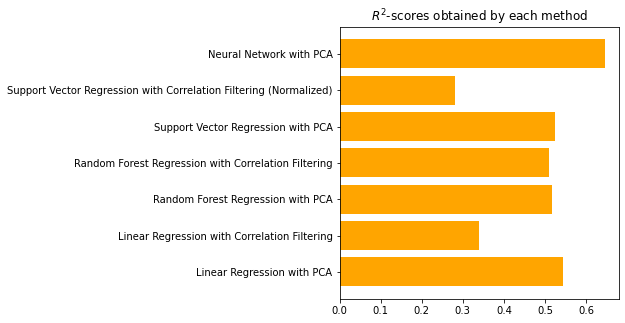

In [22]:
est_out = modelPCA.predict(ts_inputs)

R2_NN_PCA = r2_score(ts_target, est_out)

r2vec = [R2_lin_PCA, R2_lin_Corr, R2_rf_PCA, R2_rf_Corr, R2_svr_PCA, R2_svr_Cor_scaled, R2_NN_PCA]
r2_labels = ['Linear Regression with PCA',
            'Linear Regression with Correlation Filtering',
            'Random Forest Regression with PCA',
            'Random Forest Regression with Correlation Filtering',
            'Support Vector Regression with PCA',
            'Support Vector Regression with Correlation Filtering (Normalized)',
            'Neural Network with PCA']

fig, ax = plt.subplots(figsize=(5, 5))
ax.barh(r2_labels, r2vec, color='orange')
ax.set_title('$R^2$-scores obtained by each method');

for idx,label in enumerate(r2_labels):
    print('R^2-score obtained with '+label+' is {}'.format(r2vec[idx]))


## Part 2:

In Part 2 of the Prediction Challenge, we basically need to do the same prediction but with new test/train splits. In this case, the training will be performed without any American country, but all the testing will be performed on American countries (North or South). So firstly, we need to get the list of countries that lie either on North or South America (or in the continent of America). To do this, we basically merge our dataset with a region dataset.


In [23]:
regions = pd.read_csv('country_region.csv')[['Country', 'Region']]
cities = pd.read_excel('Cities.xls')
cities = pd.merge(cities, regions)

# Just to print the resulted merge. Only the shown columns are sliced.
america_cities = cities[cities['Region'].str.contains('America')][['City', 'Country', 'Region']]
pd.set_option('display.max_rows', 1000)
america_cities.head(3)

,City,Country,Region
0,Baltimore(MD),United States,North America
1,Milwaukee(WI),United States,North America
2,Austin(TX),United States,North America


As you can see above, we got the list of countries that lie either on North or South America. 

* Since the procedure until training a model could basically be the same we will use our already prepared dataset **df**. However it has it's **'Country'** column is encoded by integers. So we will use the dictionary that we created during the encoding of the country to decode the country list we obtained during the merge above so we could slice out the countries that lie within North or South America from our **df**.

In [24]:
# Get DataFrame for only South/ North America
country_list = cities[cities['Region'].str.contains('America')]['Country'].unique()

# Encode the country names if they exist in our dataset.
tmp = []
for country in country_list:
    try: 
        tmp.append(list(decode_dict.keys())[list(decode_dict.values()).index(country)])
    except:
        print('Error finding the country in the dataset. We possible removed it during cleaning.')
        continue
country_list = tmp

# Get cityID's since they are not getting standardized.
north_south_america = df[df.Country.isin(country_list)]


Since we are still using the same data (before splitting), we decided that we should use PCA + Neural Network approach here too because it gave the best results for us in the first part. For PCA part, there's not any reason to change why and how we picked our principle components, so we can use the already existing PCA object and transform our new splits with it.

In [25]:
ts_inputs = pca18.transform(df_inputs[df_inputs.index.isin(north_south_america.index)])
tr_inputs = pca18.transform(df_inputs[~df_inputs.index.isin(north_south_america.index)])

ts_target = df_target[df_target.index.isin(north_south_america.index)]
tr_target = df_target[~df_target.index.isin(north_south_america.index)]

* Now we need to train a new model and optimize it using our new test and train splits:

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# define the keras model
model = Sequential()
model.add(Dense(64, input_dim=np.shape(tr_inputs)[1], activation='tanh'))
model.add(Dense(64, activation='tanh'))

model.add(Dense(1, activation='linear')) # Output layer.


# compile the keras model
opt = Adam(learning_rate=1e-3)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
model.fit(tr_inputs, tr_target, epochs=90, batch_size=50, verbose=1) # Do not print the progress since 3500 epochs.


Epoch 1/90
5/5 [==============================] - 0s 804us/step - loss: 67.7026 - mean_squared_error: 67.7026
Epoch 2/90
5/5 [==============================] - 0s 998us/step - loss: 62.9678 - mean_squared_error: 62.9678
Epoch 3/90
5/5 [==============================] - 0s 803us/step - loss: 59.0603 - mean_squared_error: 59.0603
Epoch 4/90
5/5 [==============================] - 0s 1ms/step - loss: 56.2658 - mean_squared_error: 56.2658
Epoch 5/90
5/5 [==============================] - 0s 798us/step - loss: 53.6002 - mean_squared_error: 53.6002
Epoch 6/90
5/5 [==============================] - 0s 1ms/step - loss: 51.3559 - mean_squared_error: 51.3559
Epoch 7/90
5/5 [==============================] - 0s 796us/step - loss: 49.1077 - mean_squared_error: 49.1077
Epoch 8/90
5/5 [==============================] - 0s 997us/step - loss: 47.0035 - mean_squared_error: 47.0035
Epoch 9/90
5/5 [==============================] - 0s 1ms/step - loss: 44.8918 - mean_squared_error: 44.8918
Epoch 10/90
5/5 

* In the cell below predictions are made on the data using only the rows from countries within North and South America and the R2 score is printed. It can be seen that the R2 score obtained is 0.416 (above the goal).

In [28]:
est_out = model.predict(ts_inputs)
R_2 = r2_score(ts_target, est_out)
print('The obtained R^2-score is {}'.format(R_2))

The obtained R^2-score is 0.41638630585990144


It's quite natural that the performance of the model we could get is poorer than what we could get in the first part, because we had no American countries in our training set but we performed all the testing on the cities that are located on the continent of America.

For a model to be transferable, the model needs to be trained on a dataset that covers enough number of different combination of feature values that could define the target behaviour. In our case, it is seen that the model is still able to predict the target up to an extent with this new data, but losing score and accuracy. 

